# IMBD reviews model selection

In [1]:
# Dependencies

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
import nltk
from collections import Counter
import string
import itertools
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalMaxPool1D, BatchNormalization, Dense, RNN, GRU, LSTM, TimeDistributed, Bidirectional, Activation, Embedding, Input, Conv1D, Dropout
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from transformers import AutoTokenizer, pipeline
from transformers import TFAutoModelForSequenceClassification, TFTrainingArguments, TFTrainer
from scipy.special import softmax
from datasets import DatasetDict, Dataset
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import to_categorical
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

plt.style.use('ggplot')

# Define mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


### Data preprocessing

In [2]:
# Data imports
with open('reviews.txt', 'r') as f:
  reviews = f.read()
with open('labels.txt', 'r') as f:
  labels = f.read()
  
# Remove punctuation
reviews = "".join([char for char in reviews if char not in string.punctuation])

reviews = reviews.split('\n')
labels = labels.split('\n')

# Tokenization, Lemmatization, Stemming, Stopwords. Label numerical encoding
reviews_tokenized = []
reviews_tokenized_joined = []
for review in reviews:
  splitted_review = nltk.word_tokenize(review)
  splitted_review = [word for word in splitted_review if word not in stop_words]
  splitted_review = [WordNetLemmatizer().lemmatize(w) for w in splitted_review]
  splitted_review = [PorterStemmer().stem(w).strip() for w in splitted_review]
  reviews_tokenized.append(splitted_review)
  joined_review = ' '.join(splitted_review)
  reviews_tokenized_joined.append(joined_review)
  
# Remove empty reviews and the corresponding labels
empty_idx = []
for i, review in enumerate(reviews_tokenized):
  if len(review) == 0:
    empty_idx.append(i)
    
for i in empty_idx:
  reviews_tokenized.pop(i)
  reviews_tokenized_joined.pop(i)
  reviews.pop(i)
  labels.pop(i)
  
reviews_unrolled = list(itertools.chain(*reviews_tokenized))
labels = [1 if label == "positive" else 0 for label in labels]

### Part 1. Multinomial Naive Bayes with Count Vectorizer

In [1]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

MultinomialNB_CountVectorizer_start_time = time.time()

# Count vectorizer feature transformation
count_vector = CountVectorizer(stop_words = 'english', binary = False)

training_data = count_vector.fit_transform(X_train)
test_data = count_vector.transform(X_test)

# Multinomial Naive Bayes model predictions
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB_CountVectorizer_predictions = naive_bayes.predict(test_data)

MultinomialNB_CountVectorizer_end_time = time.time()
MultinomialNB_CountVectorizer_execution_time = MultinomialNB_CountVectorizer_end_time - MultinomialNB_CountVectorizer_start_time

# Model evaluation
print('MultinomialNB CountVectorizer Training time: {} seconds'. format(round(MultinomialNB_CountVectorizer_execution_time, 2)))
print('MultinomialNB CountVectorizer Accuracy score: ', format(accuracy_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer Precision score: ', format(precision_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer Recall score: ', format(recall_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer F1 score: ', format(f1_score(y_test, MultinomialNB_CountVectorizer_predictions)))

# Model evaluation dictionary
MultinomialNB_CountVectorizer_results = {'Name': "MultinomialNB CountVectorizer", 
                                         "Training Time": round(MultinomialNB_CountVectorizer_execution_time, 2),
                                         "Accuracy score": accuracy_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "Precision score": precision_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "Recall score": recall_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "F1 score": f1_score(y_test, MultinomialNB_CountVectorizer_predictions)}

NameError: name 'train_test_split' is not defined

In [ ]:
# Write the results into a pickle file
filename = 'results_dict_list_IMDB.pickle'

results_dict_list = [MultinomialNB_CountVectorizer_results]

with open(filename, 'wb') as f:
    pickle.dump(results_dict_list, f)  

### Part 2. Multinomial Naive Bayes with TF-IDF

In [2]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

MultinomialNB_tfidf_start_time = time.time()

# TF-IDF feature transformation
tfidf = TfidfVectorizer(stop_words = 'english', binary = False)

training_data = tfidf.fit_transform(X_train)
test_data = tfidf.transform(X_test)

# Multinomial Naive Bayes model predictions
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB_tfidf_predictions = naive_bayes.predict(test_data)

MultinomialNB_tfidf_end_time = time.time()
MultinomialNB_tfidf_execution_time = MultinomialNB_tfidf_end_time - MultinomialNB_tfidf_start_time

# Model evaluation
print('MultinomialNB tfidf Training time: {} seconds'. format(round(MultinomialNB_tfidf_execution_time, 2)))
print('MultinomialNB tfidf Accuracy score: ', format(accuracy_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf Precision score: ', format(precision_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf Recall score: ', format(recall_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf F1 score: ', format(f1_score(y_test, MultinomialNB_tfidf_predictions)))

# Model evaluation dictionary
MultinomialNB_tfidf_results = {'Name': "MultinomialNB tfidf", 
                                         "Training Time": round(MultinomialNB_tfidf_execution_time, 2),
                                         "Accuracy score": accuracy_score(y_test, MultinomialNB_tfidf_predictions),
                                         "Precision score": precision_score(y_test, MultinomialNB_tfidf_predictions),
                                         "Recall score": recall_score(y_test, MultinomialNB_tfidf_predictions),
                                         "F1 score": f1_score(y_test, MultinomialNB_tfidf_predictions)}

NameError: name 'train_test_split' is not defined

In [ ]:
# Update the results pickle file
def update_the_results_file(filename=filename, model_name):
  with open(filename, 'rb') as f:
    results_dict_list = pickle.load(f)
    
  results_dict_list.append(model_name)

  with open(filename, 'wb') as f:
      pickle.dump(results_dict_list, f)
      
update_the_results_file(MultinomialNB_tfidf_results)

### Part 3. Vaders sentiment classifier

#### Extra preprocessing step

In [5]:
# Create dataframe for convenience
df = pd.DataFrame({'Text': reviews, 'Label': labels})
df = df.reset_index()
df['Id'] = df['index'] + 1
df.drop('index', axis = 1, inplace = True)
df = df[['Id', 'Text', 'Label']]
df.head()

,Id,Text,Label
0,1,bromwell high is a cartoon comedy it ran at t...,1
1,2,story of a man who has unnatural feelings for ...,0
2,3,homelessness or houselessness as george carli...,1
3,4,airport starts as a brand new luxury pla...,0
4,5,brilliant over acting by lesley ann warren b...,1


In [6]:
vader_start_time = time.time()

# Define Vader Sentiment analyzer model
sia = SentimentIntensityAnalyzer()

# Get the results
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)
  
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index': 'Id'})
vaders = vaders.merge(df, how = 'left')
vaders['Predicted_Label'] = np.where(vaders['compound'] >= 0, 1, 0)

vader_end_time = time.time()
vader_execution_time = vader_end_time - vader_start_time

vaders.head()

  0%|          | 0/25000 [00:00<?, ?it/s]

,Id,neg,neu,pos,compound,Text,Label,Predicted_Label
0,1,0.044,0.916,0.041,-0.1027,bromwell high is a cartoon comedy it ran at t...,1,0
1,2,0.108,0.746,0.146,0.7003,story of a man who has unnatural feelings for ...,0,1
2,3,0.120,0.733,0.147,0.9311,homelessness or houselessness as george carli...,1,1
3,4,0.161,0.692,0.147,-0.9180,airport starts as a brand new luxury pla...,0,0
4,5,0.077,0.738,0.185,0.9657,brilliant over acting by lesley ann warren b...,1,1


In [3]:
# Model evaluation
print('Vader Training time: {} seconds'. format(round(vader_execution_time, 2)))
print('Vader Accuracy score: ', format(accuracy_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader Precision score: ', format(precision_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader Recall score: ', format(recall_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader F1 score: ', format(f1_score(vaders['Label'], vaders['Predicted_Label'])))

# Model evaluation dictionary
vader_results = {'Name': "Vaders Analyser", 
                                         "Training Time": round(vader_execution_time, 2),
                                         "Accuracy score": accuracy_score(vaders['Label'], vaders['Predicted_Label']),
                                         "Precision score": precision_score(vaders['Label'], vaders['Predicted_Label']),
                                         "Recall score": recall_score(vaders['Label'], vaders['Predicted_Label']),
                                         "F1 score": f1_score(vaders['Label'], vaders['Predicted_Label'])}

NameError: name 'vader_execution_time' is not defined

In [ ]:
update_the_results_file(vader_results)

### Part 4. RNN manual implementation

In [8]:
# Create vocabulary, word2index reference and convert the reviews into numerical form
vocab_size = 10000

word_counter = Counter(reviews_unrolled)
word_counter = dict(word_counter.most_common(vocab_size))
word2index = {k:i for i,k in enumerate(word_counter.keys(), start = 3)}

# Convert reveies to integers
reviews_int = []
for review in reviews_tokenized:
  cur_review = [1]
  for word in review:
    if word in word2index.keys():
      cur_review.append(word2index[word])
    else:
      cur_review.append(2)
  reviews_int.append(cur_review)
  
# Pad sequences
padded_reviews = pad_sequences(reviews_int, maxlen = 500, padding = 'pre', truncating = 'pre')

# Train test split on padded sequences
X_train, X_test, y_train, y_test = train_test_split(padded_reviews, labels, test_size = 0.2, random_state = 1)

X_train = np.array(X_train).reshape(20000, 500)
X_test = np.array(X_test).reshape(5000, 500)

y_train = np.array(y_train).reshape(20000, 1)
y_test = np.array(y_test).reshape(5000, 1)

In [9]:
# Define the model
dropout_rate = 0.5

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='best_RNN_manual_model_IMDB.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

inputs = Input(shape = (X_train.shape[1:]))
mask = tf.keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
x = Embedding(input_dim = vocab_size, output_dim = 128, input_length = 200)(inputs)
x = Conv1D(filters = 200, kernel_size = 13, strides = 1, padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(128, return_sequences = True)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(128, return_sequences = False)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 500, 200)          333000    
                                                                 
 batch_normalization (BatchN  (None, 500, 200)         800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 500, 200)          0         
                                                                 
 gru (GRU)                   (None, 500, 128)          126720    
                                                             

In [10]:
# Train the model

Manual_RNN_start_time = time.time()

history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_data = (X_test, y_test), callbacks = [checkpoint, early_stop])

Manual_RNN_end_time = time.time()
Manual_RNN_execution_time = Manual_RNN_end_time - Manual_RNN_start_time

Epoch 1/10
157/157 [==============================] - 28s 82ms/step - loss: 0.7418 - accuracy: 0.5449 - val_loss: 0.6100 - val_accuracy: 0.6486
Epoch 2/10
157/157 [==============================] - 12s 79ms/step - loss: 0.3326 - accuracy: 0.8590 - val_loss: 0.3674 - val_accuracy: 0.8446
Epoch 3/10
157/157 [==============================] - 12s 79ms/step - loss: 0.2009 - accuracy: 0.9247 - val_loss: 0.3175 - val_accuracy: 0.8708
Epoch 4/10
157/157 [==============================] - 12s 78ms/step - loss: 0.1401 - accuracy: 0.9466 - val_loss: 0.3305 - val_accuracy: 0.8672
Epoch 5/10
157/157 [==============================] - 12s 77ms/step - loss: 0.0869 - accuracy: 0.9700 - val_loss: 0.5444 - val_accuracy: 0.8564
Epoch 6/10
157/157 [==============================] - 12s 77ms/step - loss: 0.0656 - accuracy: 0.9761 - val_loss: 0.5827 - val_accuracy: 0.8584
Epoch 6: early stopping


In [4]:
# Model predictions
Manual_RNN_predictions = model.predict(X_test)

Manual_RNN_predictions_results = []
for i in Manual_RNN_predictions:
  if i[0] >= 0.5:
    Manual_RNN_predictions_results.append(1)
  else:
    Manual_RNN_predictions_results.append(0)

# Model evaluation
print('Manual RNN Training time: {} seconds'. format(round(Manual_RNN_execution_time, 2)))
print('Manual RNN Accuracy score: ', format(accuracy_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN Precision score: ', format(precision_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN Recall score: ', format(recall_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN F1 score: ', format(f1_score(y_test, Manual_RNN_predictions_results)))

# Model evaluation dictionary
Manual_RNN_results = {'Name': "Manual RNN", 
                 "Training Time": round(Manual_RNN_execution_time, 2),
                 "Accuracy score": accuracy_score(y_test, Manual_RNN_predictions_results),
                 "Precision score": precision_score(y_test, Manual_RNN_predictions_results),
                 "Recall score": recall_score(y_test, Manual_RNN_predictions_results),
                 "F1 score": f1_score(y_test, Manual_RNN_predictions_results)}

NameError: name 'model' is not defined

In [ ]:
update_the_results_file(Manual_RNN_results)

### Part 5. Universal Sentence encoder transfer learning

In [12]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train).reshape(20000, 1)
y_test = np.array(y_test).reshape(5000, 1)

In [13]:
# Download the Universal Sentence encoder layer for transfer learning
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                         input_shape = [],
                                         dtype=tf.string,
                                         trainable = False)

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='best_sentence_encoder_model_IMDB.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

# Define the model
model = Sequential([
  sentence_encoder_layer,
  Dense(1024, activation = 'relu'),
  Dense(1024, activation = 'relu'),
  Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 258,373,761
Trainable params: 1,575,937
Non-trainable params: 256,797,824
_________________________________________________________________


In [14]:
# Train the model

Sentence_encoder_start_time = time.time()

history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_data = (X_test, y_test), callbacks = [checkpoint, early_stop])

Sentence_encoder_end_time = time.time()
Sentence_encoder_execution_time = Sentence_encoder_end_time - Sentence_encoder_start_time

Epoch 1/10
157/157 [==============================] - 23s 132ms/step - loss: 0.3673 - accuracy: 0.8411 - val_loss: 0.3215 - val_accuracy: 0.8638
Epoch 2/10
157/157 [==============================] - 20s 129ms/step - loss: 0.3129 - accuracy: 0.8668 - val_loss: 0.3106 - val_accuracy: 0.8656
Epoch 3/10
157/157 [==============================] - 19s 120ms/step - loss: 0.2850 - accuracy: 0.8810 - val_loss: 0.3320 - val_accuracy: 0.8562
Epoch 4/10
157/157 [==============================] - 18s 112ms/step - loss: 0.2526 - accuracy: 0.9003 - val_loss: 0.3196 - val_accuracy: 0.8672
Epoch 5/10
157/157 [==============================] - 19s 118ms/step - loss: 0.2073 - accuracy: 0.9210 - val_loss: 0.3601 - val_accuracy: 0.8638
Epoch 5: early stopping


In [5]:
# Model predictions
Sentence_encoder_predictions = model.predict(X_test)

Sentence_encoder_predictions_results = []
for i in Sentence_encoder_predictions:
  if i[0] >= 0.5:
    Sentence_encoder_predictions_results.append(1)
  else:
    Sentence_encoder_predictions_results.append(0)
    
# Model evaluation
print('Sentence encoder Training time: {} seconds'. format(round(Sentence_encoder_execution_time, 2)))
print('Sentence encoder Accuracy score: ', format(accuracy_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder Precision score: ', format(precision_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder Recall score: ', format(recall_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder F1 score: ', format(f1_score(y_test, Sentence_encoder_predictions_results)))

# Model evaluation dictionary
Sentence_encoder_results = {'Name': "Sentence encoder", 
                 "Training Time": round(Sentence_encoder_execution_time, 2),
                 "Accuracy score": accuracy_score(y_test, Sentence_encoder_predictions_results),
                 "Precision score": precision_score(y_test, Sentence_encoder_predictions_results),
                 "Recall score": recall_score(y_test, Sentence_encoder_predictions_results),
                 "F1 score": f1_score(y_test, Sentence_encoder_predictions_results)}

NameError: name 'model' is not defined

In [ ]:
update_the_results_file(Sentence_encoder_results)

### Part 6. Roberta Huggingface model

In [17]:
# Download the pretrained model
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [18]:
# Auxillary polarity scores function
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'tf')
  output = model(**encoded_text)
  scores = output[0][0].numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }
  return scores_dict

In [19]:
# Predict results with each of the rows in the dataframe

Roberta_start_time = time.time()

res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)

    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f'vader_{key}'] = value

    roberta_result = polarity_scores_roberta(text)
    both_results = {**vader_result_rename, **roberta_result}
    res[myid] = both_results
    
Roberta_end_time = time.time()
Roberta_execution_time = Roberta_end_time - Roberta_start_time

  0%|          | 0/25000 [00:00<?, ?it/s]

In [20]:
# Save roberta model results
roberta_results = []
for i in range(1, len(df) + 1):
  roberta_results.append(int(res[i]['roberta_pos'] > res[i]['roberta_neg']))
  
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index': 'Id'})
results_df = results_df.merge(vaders, how = 'left')
results_df.drop(['neg', 'neu', 'pos', 'compound'], axis = 1, inplace = True)

results_df['Roberta_Predictions'] = results_df['roberta_pos'] > results_df['roberta_neg']
results_df['Roberta_Predictions'] = results_df['Roberta_Predictions'].astype(int)
results_df.head(3)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text,Label,Predicted_Label,Roberta_Predictions
0,1,0.044,0.916,0.041,-0.1027,0.676270,0.275635,0.047974,bromwell high is a cartoon comedy it ran at t...,1,0,0
1,2,0.108,0.746,0.146,0.7003,0.397461,0.361816,0.240723,story of a man who has unnatural feelings for ...,0,1,0
2,3,0.120,0.733,0.147,0.9311,0.450928,0.481201,0.067932,homelessness or houselessness as george carli...,1,1,0


In [6]:
# Model evaluation
print('Roberta Training time: {} seconds'. format(round(Roberta_execution_time, 2)))
print('Roberta Accuracy score: ', format(accuracy_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta Precision score: ', format(precision_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta Recall score: ', format(recall_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta F1 score: ', format(f1_score(results_df['Label'], results_df['Roberta_Predictions'])))

# Model evaluation dictionary
Roberta_results = {'Name': "Roberta", 
                 "Training Time": round(Roberta_execution_time, 2),
                 "Accuracy score": accuracy_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "Precision score": precision_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "Recall score": recall_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "F1 score": f1_score(results_df['Label'], results_df['Roberta_Predictions'])}

NameError: name 'Roberta_execution_time' is not defined

In [ ]:
update_the_results_file(Roberta_results)

### Part 7. Distilbert Fine Tuned huggingface (native tensorflow)

In [3]:
# Define huggingface dataset object and train test split
ds = Dataset.from_dict({'reviews': reviews, 'labels': labels})
dataset = ds.train_test_split()

# Model name and hyperparameters
checkpoint = 'distilbert-base-uncased'
batch_size = 16
max_length = 300

# Tokenizer object
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenization auxillary function
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['reviews'], padding='max_length', truncation=True, max_length = max_length)
  
# Tokenized dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_dataset['train']
test_dataset = tokenized_dataset['test']
train_dataset = train_dataset.remove_columns(['reviews']).with_format('tensorflow')
test_dataset = test_dataset.remove_columns(['reviews']).with_format('tensorflow')

# Training features and tensorflow dataset
train_features = {x: train_dataset[x] for x in tokenizer.model_input_names}
train_set = tf.data.Dataset.from_tensor_slices((train_features, train_dataset['labels'])).shuffle(1000).batch(batch_size)

test_features = {x: test_dataset[x] for x in tokenizer.model_input_names}
test_set = tf.data.Dataset.from_tensor_slices((test_features, test_dataset['labels'])).shuffle(1000).batch(batch_size)

test_set_for_preds = tf.data.Dataset.from_tensor_slices((test_features, test_dataset['labels'])).batch(batch_size)

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

In [4]:
# Download pretrained model from checkpoint (Only the head layer is trainable)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.layers[0].trainable = True

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='HF_BERT_finetuned_tf_model_IMDB.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

# Model compilation
model.compile(
  optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-6),
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy']
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [5]:
HF_TF_finetuned_start_time = time.time()

# Model finetuning
history = model.fit(train_set,
                   validation_data = test_set,
                   epochs = 200,
                   batch_size = batch_size,
                   callbacks = [checkpoint, early_stop])

HF_TF_finetuned_end_time = time.time()
HF_TF_finetuned_execution_time = HF_TF_finetuned_end_time - HF_TF_finetuned_start_time

Epoch 1/200
1172/1172 [==============================] - 266s 221ms/step - loss: 0.3245 - accuracy: 0.8602 - val_loss: 0.2484 - val_accuracy: 0.8990
Epoch 2/200
1172/1172 [==============================] - 248s 212ms/step - loss: 0.2067 - accuracy: 0.9220 - val_loss: 0.2402 - val_accuracy: 0.9051
Epoch 3/200
1172/1172 [==============================] - 251s 214ms/step - loss: 0.1551 - accuracy: 0.9445 - val_loss: 0.2390 - val_accuracy: 0.9094
Epoch 4/200
1172/1172 [==============================] - 251s 214ms/step - loss: 0.1158 - accuracy: 0.9619 - val_loss: 0.3026 - val_accuracy: 0.8997
Epoch 5/200
1172/1172 [==============================] - 254s 217ms/step - loss: 0.0853 - accuracy: 0.9744 - val_loss: 0.3206 - val_accuracy: 0.8992
Epoch 6/200
1172/1172 [==============================] - 251s 214ms/step - loss: 0.0650 - accuracy: 0.9823 - val_loss: 0.3329 - val_accuracy: 0.8994
Epoch 6: early stopping


In [7]:
predictions = model.predict(test_set_for_preds)
predictions = tf.math.argmax(tf.nn.softmax(predictions[0], axis = -1), axis = -1)
predictions = tf.cast(predictions, dtype = tf.int32)

# Model evaluation
print('HF_TF_finetuned Training time: {} seconds'. format(round(HF_TF_finetuned_execution_time, 2)))
print('HF_TF_finetuned Accuracy score: ', format(accuracy_score(predictions, test_dataset['labels'])))
print('HF_TF_finetuned Precision score: ', format(precision_score(predictions, test_dataset['labels'])))
print('HF_TF_finetuned Recall score: ', format(recall_score(predictions, test_dataset['labels'])))
print('HF_TF_finetuned F1 score: ', format(f1_score(predictions, test_dataset['labels'])))

# Model evaluation dictionary
HF_TF_finetuned_results = {'Name': "HF_TF_finetuned", 
                 "Training Time": round(HF_TF_finetuned_execution_time, 2),
                 "Accuracy score": accuracy_score(predictions, test_dataset['labels']),
                 "Precision score": precision_score(predictions, test_dataset['labels']),
                 "Recall score": recall_score(predictions, test_dataset['labels']),
                 "F1 score": f1_score(predictions, test_dataset['labels'])}

NameError: name 'model' is not defined

In [ ]:
update_the_results_file(HF_TF_finetuned_results)

### Part 8. Distilbert Fine Tuned huggingface (trainer object)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

In [37]:
max_length = 300

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train, truncation = True, padding = True, max_length = max_length)
test_encodings = tokenizer(X_test, truncation = True, padding = True, max_length = max_length)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

In [38]:
training_args = TFTrainingArguments(
  output_dir = './results',
  num_train_epochs = 10,
  per_device_eval_batch_size = 4,
  per_device_train_batch_size = 4,
  warmup_steps = 500,
  weight_decay = 0.01,
  logging_dir = './logs',
  logging_steps = 10,
  eval_steps = 50,
)

In [39]:
HF_trainer_finetuned_start_time = time.time()

with training_args.strategy.scope():
  model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
  
trainer = TFTrainer(
  model = model,
  args = training_args,
  train_dataset = train_dataset,
  eval_dataset = test_dataset
)

trainer.train()

HF_trainer_finetuned_end_time = time.time()
HF_trainer_finetuned_execution_time = HF_trainer_finetuned_end_time - HF_trainer_finetuned_start_time

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_119', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [8]:
predictions = trainer.predict(test_dataset)
predictions = tf.math.argmax(tf.nn.softmax(predictions[0], axis = -1), axis = -1)

# Model evaluation
print('HF_trainer_finetuned Training time: {} seconds'. format(round(HF_trainer_finetuned_execution_time, 2)))
print('HF_trainer_finetuned Accuracy score: ', format(accuracy_score(predictions, y_test)))
print('HF_trainer_finetuned Precision score: ', format(precision_score(predictions, y_test)))
print('HF_trainer_finetuned Recall score: ', format(recall_score(predictions, y_test)))
print('HF_trainer_finetuned F1 score: ', format(f1_score(predictions, y_test)))

# Model evaluation dictionary
HF_trainer_finetuned_results = {'Name': "HF_trainer_finetuned", 
                 "Training Time": round(HF_trainer_finetuned_execution_time, 2),
                 "Accuracy score": accuracy_score(predictions, y_test),
                 "Precision score": precision_score(predictions, y_test),
                 "Recall score": recall_score(predictions, y_test),
                 "F1 score": f1_score(predictions, y_test)}

NameError: name 'trainer' is not defined

In [ ]:
update_the_results_file(HF_trainer_finetuned_results)

### Part 9. High level pipeline huggingface

In [5]:
classifier = pipeline('sentiment-analysis', device = 0)

HF_pipeline_start_time = time.time()
results = []
for i in range(len(reviews)):
  results.append(classifier(reviews[i]))
  if i % 1000 == 0:
    print(i)
HF_pipeline_end_time = time.time()
HF_pipeline_execution_time = HF_pipeline_end_time - HF_pipeline_start_time
HF_pipeline_execution_time

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


2024.9564533233643

In [9]:
preds = []
for result in results:
  if result[0]['label'] == "POSITIVE":
    preds.append(1)
  else:
    preds.append(0)
    
# Model evaluation
print('HF_pipeline Training time: {} seconds'. format(round(HF_pipeline_execution_time, 2)))
print('HF_pipeline Accuracy score: ', format(accuracy_score(preds, labels)))
print('HF_pipeline Precision score: ', format(precision_score(preds, labels)))
print('HF_pipeline Recall score: ', format(recall_score(preds, labels)))
print('HF_pipeline F1 score: ', format(f1_score(preds, labels)))

# Model evaluation dictionary
HF_pipeline_results = {'Name': "HF_pipeline", 
                 "Training Time": round(HF_pipeline_execution_time, 2),
                 "Accuracy score": accuracy_score(preds, labels),
                 "Precision score": precision_score(preds, labels),
                 "Recall score": recall_score(preds, labels),
                 "F1 score": f1_score(preds, labels)}

NameError: name 'results' is not defined

In [ ]:
update_the_results_file(HF_pipeline_results)

### All models summary

In [33]:
# Create a DataFrame with a summary for all models and KPIs

file_name = filename

with open(file_name, 'rb') as f:
    results_dict_list = pickle.load(f)
df = pd.DataFrame(results_dict_list)
df

,Name,Training Time,Accuracy score,Precision score,Recall score,F1 score
0,MultinomialNB CountVectorizer,2.21,0.85820,0.862112,0.847030,0.854504
1,MultinomialNB tfidf,2.18,0.86400,0.858757,0.865745,0.862237
2,Vaders Analyser,35.96,0.69088,0.643510,0.855920,0.734670
3,Manual RNN,88.80,0.87080,0.837054,0.915378,0.874466
4,Sentence encoder,98.50,0.86580,0.868150,0.857201,0.862641
5,Roberta,3602.97,0.85152,0.865618,0.832240,0.848601
6,HF_TF_finetuned,1520.93,0.90928,0.911830,0.908660,0.910242
7,HF_trainer_finetuned,320.79,0.90980,0.921888,0.897426,0.909492
8,HF_pipeline,2024.96,0.85864,0.775920,0.929735,0.845892


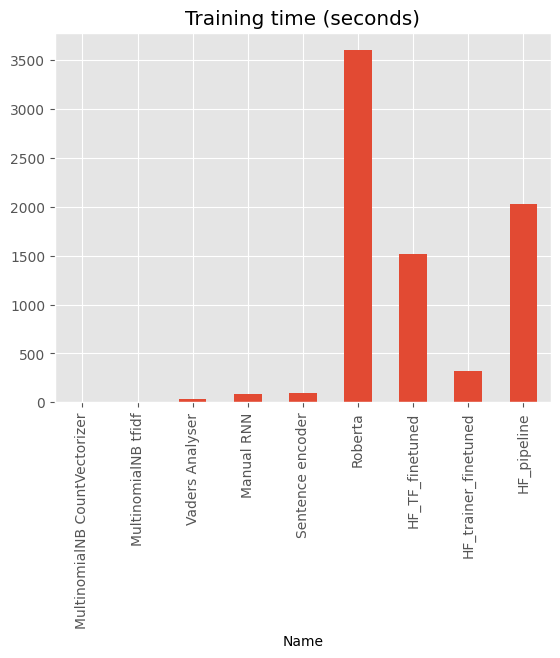

In [34]:
# Training time
df.plot(kind='bar', x='Name', y='Training Time')
plt.title("Training time (seconds)")
plt.legend().remove()

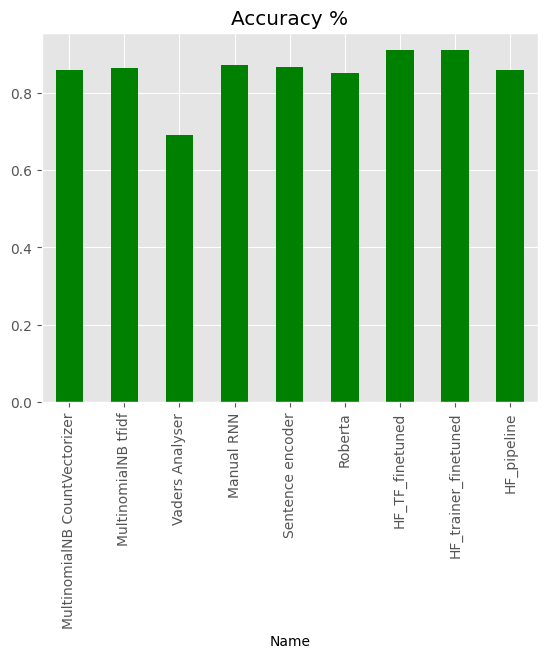

In [35]:
# Accuracy
df.plot(kind='bar', x='Name', y='Accuracy score', color = 'green')
plt.title("Accuracy %")
plt.legend().remove()

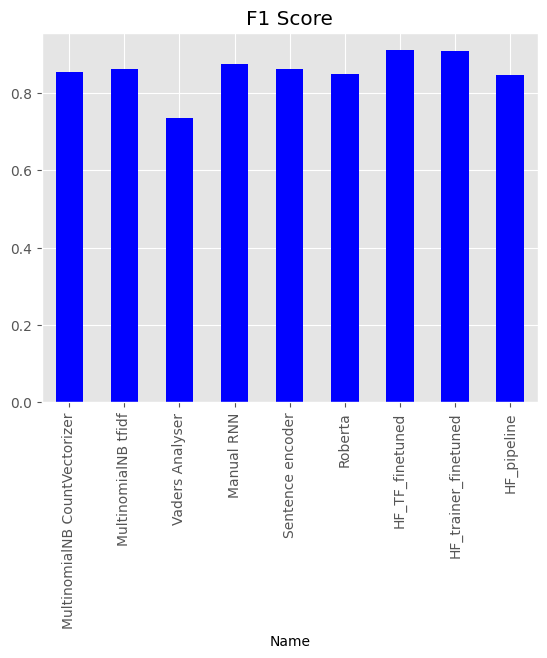

In [36]:
# F1 Scores
df.plot(kind='bar', x='Name', y='F1 score', color = 'blue')
plt.title("F1 Score")
plt.legend().remove()